In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_absolute_percentage_error


## Problem Statement -> Diamond Price Prediction

In [2]:
# carat: carat weight of the diamond (0.2--5.01)
# cut: quality of the cut ( Fair, Good, Very Good, Premium, Ideal)
# Color: diamond colour, from J (worst) to D (best)
# Clarity: A measurement of how clear the diamond is (I1 (Worst), SI2,SI1,VS2,VS1, VVS2, VVS1, IF (best))
# Depth: total depth percentage: z/mean(x,y) = 2 * z / (x+y) (43--79)
# table: width of top of diamond relative to widest point (43--95)
# x: length in mm (0--10.74)
# y: width in mm (0--58.9)
# z: depth in mm (0-31.8)
# price: price in US dollars

### Step 1: Data Gathering


In [3]:
df = pd.read_csv('diamonds.csv')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### EDA- Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [5]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print("")

carat
[0.23 0.21 0.29 0.31 0.24 0.26 0.22 0.3  0.2  0.32 0.33 0.25 0.35 0.42
 0.28 0.38 0.7  0.86 0.71 0.78 0.96 0.73 0.8  0.75 0.74 0.81 0.59 0.9
 0.91 0.61 0.77 0.63 0.76 0.64 0.72 0.79 0.58 1.17 0.6  0.83 0.54 0.98
 0.52 1.01 0.53 0.84 0.51 1.05 0.55 0.87 1.   0.57 0.82 1.04 0.93 1.2
 0.99 0.34 0.43 0.36 0.95 0.89 1.02 0.97 0.56 0.85 0.92 1.27 0.66 1.12
 0.68 1.03 0.62 1.22 1.08 0.88 0.5  1.19 0.39 0.65 1.24 1.5  0.27 0.41
 1.13 1.06 0.69 0.4  1.14 0.94 1.29 1.52 1.16 1.21 1.23 1.09 0.67 1.11
 1.1  1.18 1.15 1.25 1.07 1.28 1.51 0.37 1.31 1.26 1.39 1.44 1.35 1.3
 1.32 1.41 1.36 1.45 1.34 1.58 1.54 1.38 1.33 1.74 1.64 1.47 1.4  1.55
 1.95 2.   1.37 1.83 1.62 1.57 1.69 2.06 1.72 1.66 2.14 1.49 1.46 2.15
 1.96 2.22 1.7  1.53 1.85 2.01 2.27 1.68 1.56 1.81 1.65 1.82 2.03 1.73
 1.59 1.42 1.43 2.08 1.48 1.6  2.49 1.71 2.02 2.07 3.   2.21 2.1  1.91
 2.25 2.17 2.32 2.72 1.61 2.23 2.11 2.05 1.63 2.3  2.31 1.75 2.04 2.12
 1.77 2.5  1.8  1.67 1.84 2.2  3.01 1.88 2.33 2.68 2.34 1.9  2.16 2.74
 1.

#### Checking data for Outliers

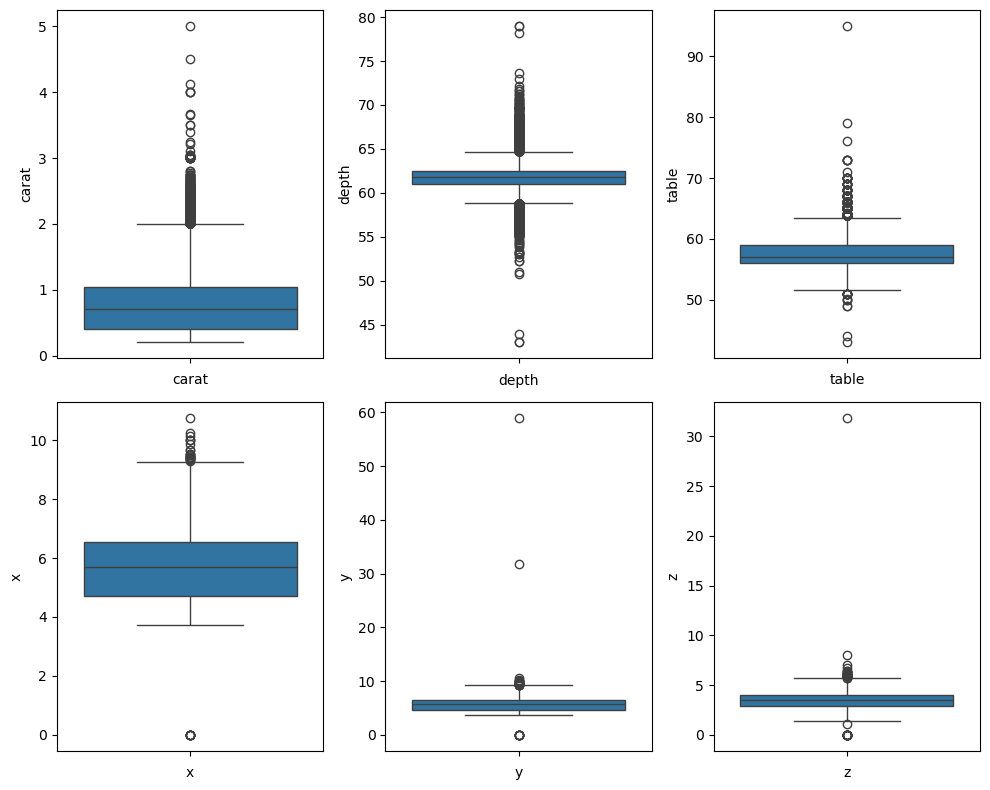

In [9]:
fig, axs = plt.subplots(2,3,figsize=(10,8))
plt1 = sns.boxplot(df['carat'], ax = axs[0,0]).set(xlabel='carat')
plt2 = sns.boxplot(df['depth'],ax = axs[0,1]).set(xlabel='depth')
plt3 = sns.boxplot(df['table'],ax=axs[0,2]).set(xlabel='table')
plt1 = sns.boxplot(df['x'], ax=axs[1,0]).set(xlabel='x')
plt2 = sns.boxplot(df['y'], ax = axs[1,1]).set(xlabel='y')
plt3 = sns.boxplot(df['z'], ax= axs[1,2]).set(xlabel='z')

plt.tight_layout()

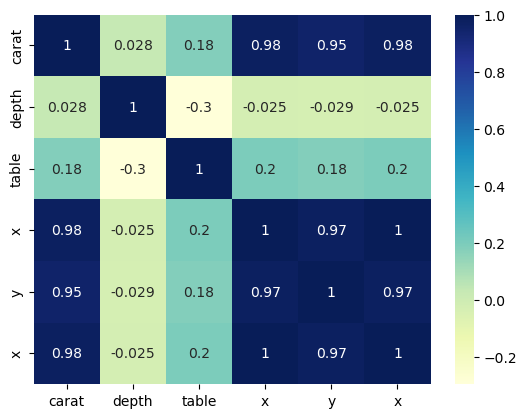

In [15]:
dataplot = sns.heatmap(df[['carat','depth','table','x','y','x']].corr(),cmap='YlGnBu', annot=True)

### Step 3: Train Test Split and Data Scaling

In [22]:
def train_test_split_and_features(df):
    y = df['price']
    X = df.drop('price',axis=1)
    X = pd.get_dummies(X,dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)
    print(X.head(5))
    print(X.columns)
    features = list(X.columns)
    return X_train,X_test, y_train, y_test, features

In [23]:
X_train, X_test, y_train, y_test, features = train_test_split_and_features(df)

   carat  depth  table  ...  clarity_VS2  clarity_VVS1  clarity_VVS2
0   0.23   61.5   55.0  ...            0             0             0
1   0.21   59.8   61.0  ...            0             0             0
2   0.23   56.9   65.0  ...            0             0             0
3   0.29   62.4   58.0  ...            1             0             0
4   0.31   63.3   58.0  ...            0             0             0

[5 rows x 26 columns]
Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Fair', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')


In [24]:
X_train.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
26546,2.01,58.1,64.0,8.23,8.19,4.77,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
9159,1.01,60.0,60.0,6.57,6.49,3.92,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14131,1.10,62.5,58.0,6.59,6.54,4.10,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
15757,1.50,61.5,65.0,7.21,7.17,4.42,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
24632,1.52,62.1,57.0,7.27,7.32,4.53,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


### Step 4: Fit and Evaluate Model

In [25]:
param_grid = [{'learning_rate':[0.1,0.2,0.3],
               'max_depth': [3,4,5],
               'subsample':[0.8,0.9],
               'colsample_bytree':[0.8,0.9],
               'n_estimators':[50]
}]

In [26]:
model = XGBRegressor(random_state=0)
search = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,verbose=5,scoring='r2')
search.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.949 total time=   2.9s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.944 total time=   0.2s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.946 total time=   0.2s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.947 total time=   0.2s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=0.949 total time=   0.2s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.948 total time=   0.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.9;, score=0.945 total time=   0.3s
[CV 3/5] END colsampl

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid=[{'colsample_bytree': [0.8, 0.9],
                          'learning_rate': [0.1, 0.2, 0.3],
                          'max_depth': [3, 4, 5], 'n_estimators': [50],
                          'subsample': [0.8, 0.9]}],
             scoring='r2', verbose=5)

In [27]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(('mean_test_score'), inplace=True, ascending=False)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.265764,0.097274,0.024773,0.002736,0.9,0.3,5,50,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.3...",0.978488,0.977260,0.978552,0.978091,0.978799,0.978238,0.000539,1
34,0.500627,0.231178,0.037839,0.014416,0.9,0.3,5,50,0.8,"{'colsample_bytree': 0.9, 'learning_rate': 0.3...",0.978529,0.977003,0.977820,0.977969,0.979018,0.978068,0.000681,2
17,0.249354,0.079202,0.028538,0.004817,0.8,0.3,5,50,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.978901,0.976849,0.978143,0.978118,0.977851,0.977972,0.000662,3
16,0.386309,0.254253,0.021691,0.002707,0.8,0.3,5,50,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.978272,0.976745,0.977726,0.977971,0.978618,0.977866,0.000635,4
28,0.240027,0.119553,0.024706,0.009549,0.9,0.2,5,50,0.8,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.978632,0.976538,0.977326,0.977820,0.978325,0.977728,0.000743,5
29,0.294890,0.087847,0.022660,0.001850,0.9,0.2,5,50,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.977957,0.976208,0.977122,0.977601,0.978449,0.977467,0.000765,6
10,0.382375,0.175847,0.020740,0.003888,0.8,0.2,5,50,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.978262,0.975708,0.977086,0.977358,0.978535,0.977390,0.001000,7
11,0.296711,0.090304,0.024455,0.003173,0.8,0.2,5,50,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.978403,0.975889,0.976954,0.977306,0.977992,0.977309,0.000872,8
33,0.407410,0.116095,0.037660,0.009753,0.9,0.3,4,50,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.3...",0.976428,0.974382,0.975937,0.975659,0.976664,0.975814,0.000799,9
15,0.185429,0.022359,0.018745,0.001412,0.8,0.3,4,50,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.976010,0.974232,0.976526,0.975515,0.976410,0.975739,0.000832,10


In [28]:
search.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': 5,
 'n_estimators': 50,
 'subsample': 0.9}

In [30]:
model = XGBRegressor(colsample_bytree = 0.9, learning_rate = 0.3, max_depth = 5, n_estimators = 50, subsample = 0.9)
model.fit(X_train,y_train)
xgb_predict = model.predict(X_test)

In [32]:
r2_score(y_test,xgb_predict)

0.979406476020813

In [33]:
mean_absolute_error(y_test,xgb_predict)

306.6745910644531

In [34]:
mean_absolute_percentage_error(y_test,xgb_predict)

0.08829011768102646

### Step 5: Get important Features

In [36]:
importances = pd.DataFrame(model.feature_importances_)
importances['features'] = features
importances.columns = ['importance','feature']
importances.sort_values(by='importance',ascending=True,inplace=True,ignore_index=True)
importances

,importance,feature
0,0.000902,cut_Very Good
1,0.000984,cut_Good
2,0.000997,table
3,0.001161,cut_Premium
4,0.001346,depth
5,0.003237,cut_Fair
6,0.004084,clarity_VS2
7,0.007443,cut_Ideal
8,0.007814,z
9,0.007927,color_G


<BarContainer object of 26 artists>

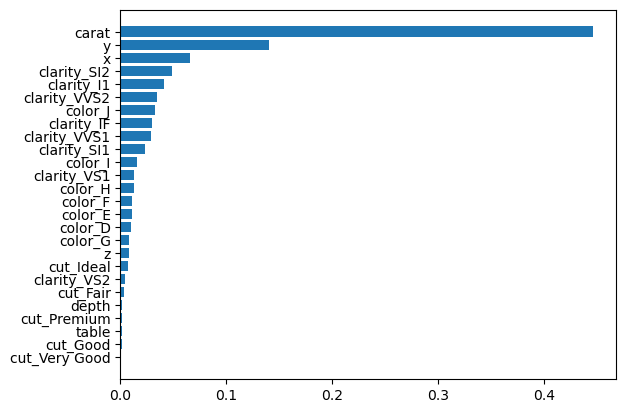

In [37]:
plt.barh(importances.feature, importances.importance)